### 演習1    
data1/SUPA00317885.fitsはtarget2の生データです。  
新しいノートブックファイルを作成し、
1. imexamでバックグラウンドの値とばらつき、星の特徴量、を調べる。
2. imstatでカウント値のmedian, mean, standard deviationを求める。
3. imarithを使って、全pixelからmedian値を引く。

#### 解答例  

ds9を立ち上げておき次を実行する。


In [1]:
from pyraf import iraf

In [2]:
iraf.display('data1/SUPA00317885.fits', 1)

z1=10049.72 z2=10166.4


In [3]:
iraf.imexam('data1/SUPA00317885.fits', 1)

#            SECTION     NPIX     MEAN   MEDIAN   STDDEV      MIN      MAX
[1303:1307,2074:2078]       25   10108.   10107.    7.175   10094.   10124.
#   COL    LINE    COORDINATES
#     R    MAG    FLUX     SKY    PEAK    E   PA BETA ENCLOSED   MOFFAT DIRECT
 941.04 1919.53 941.04 1919.53
  19.15  12.79  76569.  10108.   1469. 0.08  -84 3.00     6.17     6.38   6.38


In [4]:
iraf.imstat.unlearn()

In [5]:
iraf.imstat.fields = 'midpt, mean, stddev'

In [6]:
iraf.imstat('data1/SUPA00317885.fits')

#     MIDPT      MEAN    STDDEV
     10107.    10107.     116.6


In [7]:
iraf.imarith('data1/SUPA00317885.fits', '-', 10107, 'ex1.fits')

### 演習2 

**2-1.**  
別ターゲットtarget2を観測した、'./data1/SUPA00317885.fits' について、バイアス引き+フラット割りの処理をしましょう。
これは5番フレームです。フィルターも同じBバンドなので、フラット割りには、'bflatn5.fits'が使えます。  
この結果のフレームを'btarget2n5.fits'と呼ぶことにします。(後の演習で利用します)  

**2-2.**  
target1を観測した2番フレームの生データ'./data2/SUPA00317702.fits' について、
バイアス引き+フラット割りの処理をしましょう。
先ほどの5番フレームとは違い、これは2番フレームなので、2番フレームのためのフラットを作成する必要があります。  
(1) './data2/SUPA00317502.fits' を規格化したものをフラットとして作成する。(1枚フラット)  
(2) './data2/SUPA003175[0-6]2.fits' から平均のフラットを作成する。  
(3) 上のどちらかのフラットを使って、バイアス引き後のフラット割りを行う。

注意 : 2番フレームはオーバースキャン領域が5番とは異なる。  


#### 解答例  

**2-1.**

In [8]:
iraf.unlearn('imstat')
iraf.imstat.fields = 'midpt, mean, stddev'
iraf.imstat.nclip = 3

In [9]:
iraf.imstat('./data1/SUPA00317885.fits[2049:2080, *]')

#     MIDPT      MEAN    STDDEV
      9992.     9992.      4.86


In [12]:
iraf.imarith('./data1/SUPA00317885.fits', '-', 9992, 'btarget2n5.fits')
iraf.imarith('btarget2n5.fits', '/', 'bflatn5.fits', 'btarget2n5.fits')

**2-2.**　  
2番フレームのオーバースキャン領域は[:32, \*]   

(1)   まず、ドームフラットのオーバースキャン領域とそれ以外のメジアンを調べる。

In [13]:
iraf.unlearn('imstat')
iraf.imstat.fields = 'midpt, mean, stddev'
iraf.imstat.nclip = 3

In [14]:
iraf.imstat('./data2/SUPA00317502.fits[1:32, *]') 

#     MIDPT      MEAN    STDDEV
      9966.     9966.     5.436


In [15]:
iraf.imstat('./data2/SUPA00317502.fits[33:2080, *]') 

#     MIDPT      MEAN    STDDEV
     18712.    18706.     205.3


In [16]:
18712 - 9966

8746

バイアス値を引き、規格化する。 

In [17]:
iraf.imarith('./data2/SUPA00317502.fits', '-' , 9966, 'bflatn2a.fits')  
iraf.imarith('bflatn2a.fits', '/' , 8746, 'bflatn2a.fits')  

(2) 講習2のプログラムを参照する。 (コピペのうえ、修正。) 

In [18]:
import glob

iraf.imstat.fields = 'midpt'  

num = 0
comstr = ''  #  imcombineの一番目の引数となる文字列 
for img in glob.glob('./data2/SUPA003175[0-6]2.fits'):
    
    out1 = iraf.imstat(img + '[1:32, *]', format='no', Stdout=1)  #  オーバースキャン領域
    out2 = iraf.imstat(img + '[33:2080, *]', format='no', Stdout=1)  #  光のあたってる領域
    med1 = float(out1[0])  #  文字列を数値に変換
    med2 = float(out2[0])
    
    nflat =  'tmp' + str(num) + '.fits'   #  それぞれのフラットを作成
    iraf.imarith(img, '-', med1, nflat)  #  バイアス値をひく
    iraf.imarith(nflat, '/', med2 - med1, nflat) #  バイアスを考慮して規格化
    
    num += 1
    comstr += nflat + ','  #  imcombineの引数として与えるための文字列

print (comstr)  #  なぜ下でcomstr[:-1]と、末尾の一文字を削除するか理解するためにあえて表示 
    
iraf.imcombine(comstr[:-1], 'bflatn2.fits', combine='median')
iraf.imdelete(comstr[:-1])  #  中間ファイルを削除。お掃除お掃除。

tmp0.fits,tmp1.fits,tmp2.fits,tmp3.fits,tmp4.fits,tmp5.fits,tmp6.fits,

Aug 29  9:32: IMCOMBINE
  combine = median, scale = none, zero = none, weight = none
  blank = 0.
                Images 
              tmp0.fits
              tmp1.fits
              tmp2.fits
              tmp3.fits
              tmp4.fits
              tmp5.fits
              tmp6.fits

  Output image = bflatn2.fits, ncombine = 7


(3) まず、オーバースキャン領域のメジアンを調べる。

In [19]:
iraf.imstat('./data2/SUPA00317702.fits[1:32, *]')

#     MIDPT
      9969.


In [20]:
iraf.imarith('./data2/SUPA00317702.fits', '-', 9969, 'btarget1n2.fits')
iraf.imarith('btarget1n2.fits', '/', 'bflatn2.fits', 'btarget1n2.fits')

### 演習3  

演習2-1で処理をした'btarget2n5.fits'で測光をしてみましょう。  
このときも、オーバースキャン領域などの不要な部分を削除して行いましょう。  

'btarget2n5.fits'の視野の中には測光標準星は写っていません。ただし、上のtarget1と近い時間に観測したデータですので、
等級ゼロ点は同じだと仮定し、上と同じ較正値(1.672)を使ってください。

In [21]:
iraf.imcopy('btarget2n5.fits[25:2048, *]', 'btarget2n5trim.fits')

btarget2n5.fits[25:2048,*] -> btarget2n5trim.fits


In [22]:
targetfits = 'btarget2n5trim.fits'

In [23]:
iraf.display(targetfits)

z1=66.91281 z2=153.3736


In [24]:
iraf.imexam()

#   COL    LINE    COORDINATES
#     R    MAG    FLUX     SKY    PEAK    E   PA BETA ENCLOSED   MOFFAT DIRECT
 917.04 1919.54 917.04 1919.54
  19.24  12.79  76708.    115.   1483. 0.05  -83 3.00     6.06     6.41   6.41
1319.07 1815.61 1319.07 1815.61
  19.26  11.99 159723.   115.2   3011. 0.05   42 5.90     6.16     6.96   6.42
1154.12 2689.48 1154.12 2689.48
  19.55  13.39  43961.   114.8   837.7 0.09   79 3.00     6.19     6.51   6.52


fwhm = 6.4とする

In [25]:
iraf.unlearn('imstat') # iraf.imstat.unlearn() でも可
iraf.imstat.fields = 'midpt, mean, stddev'
iraf.imstat.nclip = 3

In [26]:
iraf.imstat(targetfits)

#     MIDPT      MEAN    STDDEV
      114.7     114.9     8.662


In [45]:
from iraf import apphot

target2は積分時間が30秒なので、iraf.apphot.datapars.itimeも修正することをお忘れなく。

In [27]:
med = 115.  #  背景レベルとばらつき、fwhm
std = 8.7
fwhm = 6.4

iraf.apphot.unlearn()  #  デフォルト値に戻しておく

iraf.apphot.datapars.datamax = 50000  #  サチった星を数えない
iraf.apphot.datapars.readnoise = 10 #  検出器に特有な値
iraf.apphot.datapars.epadu = 2.5 #  検出器に特有な値 gain 
iraf.apphot.datapars.itime = 30  # 積分時間 

iraf.apphot.findpars.threshold = 7  #  7シグマ以上のものを検出せよ 
iraf.apphot.findpars.sharphi = 0.8  # 星っぽくないものを除くため

#  fwhmで決まるパラメータ
iraf.apphot.datapars.fwhmpsf = fwhm   
iraf.apphot.centerpars.cbox = max(5.0, fwhm)
iraf.apphot.fitskypars.annulus = 3 * fwhm
iraf.apphot.photpars.apertures = 2 * fwhm

iraf.apphot.fitskypars.dannulus = 10.

#  背景のレベルとばらつきで決まるパラメータ
iraf.apphot.datapars.sigma = std  
iraf.apphot.datapars.datamin = med - 5 * std 

iraf.apphot.photpars.zmag = 27  # 等級のゼロ点

# IRAFと対話的(確認など)に行わないための設定
iraf.apphot.daofind.interac = 'no'
iraf.apphot.daofind.verify = 'no'
iraf.apphot.phot.interactive = 'no'  
iraf.apphot.phot.verify = 'no'
iraf.apphot.phot.verbose = 'no'

In [28]:
iraf.daofind(targetfits, output='out2.coo')

In [29]:
iraf.phot(targetfits, coords='out2.coo', output='out2.mag')

In [30]:
iraf.txdump('out2.mag', fields='xc,yc,mag,merr', expr='merr<=0.2', Stdout='result2.txt')

In [31]:
import math  #  平方根の計算をするために math モジュールをimportする

with open('result2c.txt', 'w') as fout: # result2c.txtを書き出し先ファイルとする
    with open('result2.txt') as fin:  #  result.txtを開く 
        for line in fin:  #  1行づつ読み込み 
            v = line.rstrip().split()  #  rstrip()で改行コードを削除し、split()で空白文字で行を分割
            mag = float(v[2]) - 1.672 #  等級は3列目なので、それをfloatに変換して1.672を引く
            merr = math.sqrt(float(v[3])**2 + 0.03**2) 
            print ('{} {} {:.3f} {:.3f}'.format(v[0], v[1], mag, merr), file=fout) #  書き出し

### 演習4   

(1) 下の二次元配列の演算をnumpyを用いて行ってください。
<img src='./img/ex4-1.png', width='300'> 

(2) 下の3つの二次元配列のメジアンを、numpy.stack()とnumpy.median()を用いて求めてください。
<img src='./img/ex4-2.png', width='350'> 


#### 解答例
(1) 

In [32]:
import numpy as np

In [33]:
data1 = np.array([[10, 11, 12], [20, 21, 22], [30, 31, 32]])
data2 = data1 * 10

In [34]:
data1

array([[10, 11, 12],
       [20, 21, 22],
       [30, 31, 32]])

In [35]:
data2

array([[100, 110, 120],
       [200, 210, 220],
       [300, 310, 320]])

In [36]:
data1 + data2

array([[110, 121, 132],
       [220, 231, 242],
       [330, 341, 352]])

(2) 

In [37]:
data3 = data1 * 2

In [38]:
data3

array([[20, 22, 24],
       [40, 42, 44],
       [60, 62, 64]])

In [39]:
s1 = np.stack((data1, data2, data3))

In [40]:
s1

array([[[ 10,  11,  12],
        [ 20,  21,  22],
        [ 30,  31,  32]],

       [[100, 110, 120],
        [200, 210, 220],
        [300, 310, 320]],

       [[ 20,  22,  24],
        [ 40,  42,  44],
        [ 60,  62,  64]]])

In [41]:
np.median(s1, axis=0)

array([[ 20.,  22.,  24.],
       [ 40.,  42.,  44.],
       [ 60.,  62.,  64.]])

### 演習5  

5-1. 
上のmy10x10.fitsを作成し、DS9で見てxとyが反転していることを確かめてください。

5-2. 
astropy.io.fitsとnumpyを使って以下の処理をしてください。  
(1) './data2/SUPA003175[0-6]2.fits'から2番フレーム用のフラットを作成。  
(2) './data2/SUPA00317882.fits' について、バイアス引き+フラット割りの処理  
(3) trimmingして(2)の結果からオーバスキャン部をとりのぞく。


In [42]:
from astropy.io import fits

(1) 

In [43]:
import glob

stack = np.empty((0, 4100, 2080))  #  空の配列を作成

for img in glob.glob('./data2/SUPA003175[0-6]2.fits'):

    imdata = fits.getdata(img)
    omed = np.median(imdata[:, :31])  
    imed = np.median(imdata[:, 32:]) 
    imdata = ( imdata - omed ) / (imed - omed)  
            
    stack = np.append(stack, imdata[np.newaxis, :], axis=0)
        
immed = np.median(stack, axis=0)    
immed = immed.astype(np.float32)

fits.writeto('bflatn2p.fits', immed)

(2)  

In [44]:
imdata = fits.getdata('./data2/SUPA00317882.fits') 
flat = fits.getdata('bflatn2p.fits') 
flat[np.where(flat == 0.0)] = -9999   #   0での割り算を回避
omed = np.median(imdata[:, :31])  
imdata = ( imdata - omed ) / flat 
fits.writeto('btarget2n2p.fits', imdata)

(3)  

In [45]:
imdata = fits.getdata('btarget2n2p.fits')
fits.writeto('btarget2n2ptrim.fits', imdata[:, 32:])

### 演習6 

演習3で行った'btarget2n5.fits'の測光結果を用いて、  
(1) 「光度関数のヒストグラム」と 「等級vs等級エラーのプロット」を作成してください。  
(2) FITS画像をnotebookに表示して、そこに測光した星をプロットしてください。

In [46]:
import matplotlib.pyplot as plt

(1) 

In [47]:
mlist = np.loadtxt('result2c.txt')

In [48]:
mag = mlist[:, 2]
merr = mlist[:, 3]

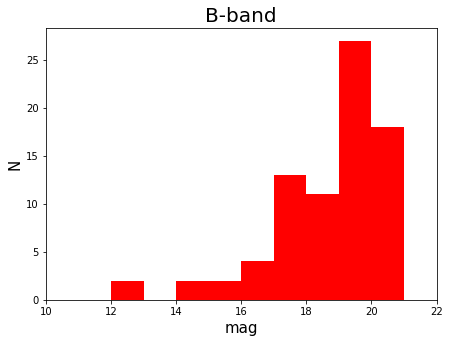

In [49]:
plt.figure(figsize=(7, 5))  #  図のサイズ 
plt.hist(mag, bins=12, range=(10,22), color='red')  # ビンの数、ヒストグラムの範囲、色を指定
plt.xlim(10, 22) # グラフのX軸の範囲
plt.title('B-band', fontsize=20)  
plt.xlabel('mag', fontsize=15)
plt.ylabel('N', fontsize=15)
plt.show()

In [50]:
img = fits.getdata('btarget2n5trim.fits')

In [51]:
med = 115.  
std = 8.7

In [52]:
xstar = mlist[:, 0] - 1
ystar= mlist[:, 1] -1 

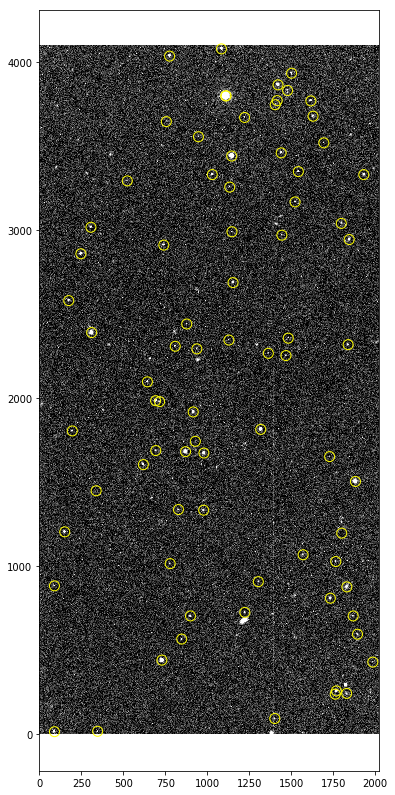

In [53]:
plt.figure(figsize=(7, 14))
plt.imshow(img, plt.cm.gray, vmin=med - std, vmax = med + 5 * std, origin='lower', 
           interpolation='none')
plt.scatter(xstar, ystar, edgecolors='yellow', facecolors='none', s=100)
plt.show()